In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from pycocotools.mask import decode, encode

import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.layers import Conv2DTranspose, ZeroPadding2D, UpSampling2D
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.applications.vgg19 import VGG19

import cv2

from pycocotools.cocostuffeval import *
from pycocotools.cocostuffhelper import *

Using TensorFlow backend.


# Data Preprocessing

In [2]:
annFile = 'annotations/stuff_val2017.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=1.93s)
creating index...
index created!


In [3]:
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard'])
imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]

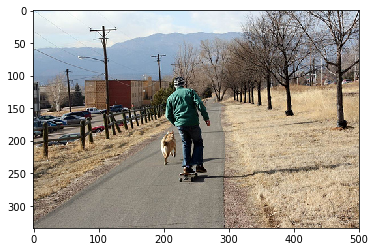

In [4]:
I = io.imread(img['coco_url'])
plt.imshow(I)
plt.show()

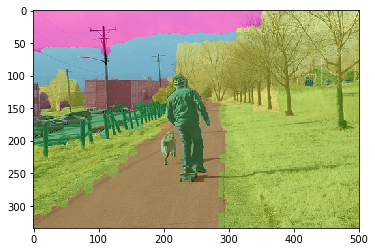

In [6]:
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


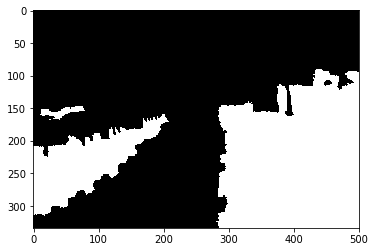

In [27]:
# 0, 124, 169
single_stuff = np.zeros_like(labelMap)
single_stuff[labelMap == 124] = 255
conc = np.zeros((334, 500, 3))
conc[:, :, 0] = single_stuff
conc[:, :, 1] = single_stuff
conc[:, :, 2] = single_stuff
plt.imshow(conc)

In [33]:
def get_ground_truth(coco, imgId, num_classes=92, class_start_id=92):
    label_map = cocoSegmentationToSegmentationMap(coco, imgId, checkUniquePixelLabel=True, includeCrowd=True)
    ground_truth = np.zeros((334, 500, num_classes))
    
    for i in range(num_classes):
        ground_truth[:, :, i][label_map == class_start_id + i] = 1
    return ground_truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


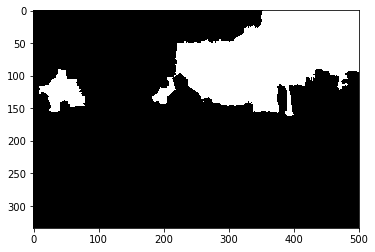

In [39]:
ground_truth = get_ground_truth(coco, 324158)
img = np.repeat(ground_truth[:, :, 77, np.newaxis], 3, axis=2)
img = img * 255
plt.imshow(img)

In [24]:
segmentationToCocoMask(labelMap, 169)

{'size': [334, 500],
 'counts': b'cQ3332Q:5O10N200001N011N011O1O1O1VFBb9`0ZFCd9?[FCa9g0hFVOh8m0oFRO43k8P1RGSOl8X1N2O100O10000O0N4M2J6OO21OC=O2O0O10000O1O1cNQG]1m8cNSG10Y1V9K5L12L3N003M1O00000000000000O2jNmFo0Z9O3M1O2N0UO_F20c0c9\\O^Fd0f901[OXFb0j9^OXF>l90OMSFGn98SFGn9OUF3LOibQ1N\\gnN4lELT:7N3O0O1O10O01N2O1N3N2L5OO0000O12N0000O10O0JHBlF<W9GgF8Z9L`F6`9;1O002N1YO\\Fc0e9]O^F?c9@aF<_9DeF9Y9IjF3]8L\\GO30H1a0OX83YG?T9KlF4g8o01O100O100001O1O1O1M3N1100000N2O;FO01O001O10OO2O1O0O2O001O10O01O1O012L3L5L3N000_HXM\\7g2dHYM^7f25OO20000O11O1N3O0OO200O2N2L4O0N03MO20000O100O2N1010O10O10OO1000O2O000002N01O0O0100O11O0000MoLhHS3W72N20O0100N11000N2001OMhLPIX3Q72N2GdLZI02]3e662N01O0O23L1O04L11NN130XI\\Le6f31OM`0EL4O0ON2O12ON1N20O02^OlK[J18S4^5QL]JQ4`5a0N20000000000^JVK`5l40O1O10000001O00001O0000O11O000000hNbJdL7HG`0_5T3]KfLd4X3dK^LlN1a5_3[11O1O001O001O001O2ZJ]L]4f3`K\\L^4W4nJkKQ5i400000aNmJcMS5]2SK]Mm4c2XKXMh4h2bKnL^4R3dK_LTO7X5Z3mKbLT4_3oK]LQ4b3^100000000N22N00000000001O00000000J6I7O11O0000001O4LL4O16JL4ImHP

# Train model

In [18]:
def gen_model():
    # output shape: (334, 500, 92)
    model = VGG19(include_top=False, input_shape=(334, 500, 3))    
    for layer in model.layers:
        layer.trainable = False
    
    out = UpSampling2D((2,2))(model.layers[-1].output)
    out = Conv2D(512, (3, 3), padding='same')(out)
    
    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((0,1))(out)
    out = Conv2D(256, (3, 3), padding='same')(out)

    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((1,0))(out)
    out = Conv2D(128, (3, 3), padding='same')(out)
    
    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(128, (3, 3), padding='same')(out)
    
    out = UpSampling2D((2,2))(out)
    out = ZeroPadding2D((1,0))(out)
    out = Conv2D(92, (3, 3), padding='same')(out)
    
    seg_model = Model(inputs=model.inputs, outputs=[out])
#     seg_model.summary()
    
    return seg_model
    
gen_model()

In [40]:
# TODO: Define loss function
def train_model(X, y):
    model = gen_model()
#     model.compile('adam', 'mse', ['mae'])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    history = model.fit(X, y, epochs=200, batch_size=32, validation_split=0.0, shuffle=True)
    model.save('model.h5')   
    return model

In [ ]:
train_model()

# Evaluation

In [25]:
#initialize COCO detections api
# resFile='%s/results/%s_%s_fake%s100_results.json'
# resFile = resFile%(dataDir, prefix, dataType, annType)
resFile='./results/instances_val2014_fakesegm100_results.json'
cocoDt=coco.loadRes(resFile)

Loading and preparing results...


UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 42490: character maps to <undefined>

In [38]:
# running evaluation
# cocoEval = COCOeval(coco,cocoDt,annType)
cocoEval = COCOeval(coco,coco.loadRes([anns[0]]),'segm')
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


KeyError: 1